In [2]:
!pwd

/Users/touchpadthamkul/zatoDev/project/bads_crm_final/master/BADS7105/writing


In [32]:
PROJECT_LINK = 'assignment4'
PATH = '/Users/touchpadthamkul/zatoDev/project/bads_crm_final/master/BADS7105'


# FRAMEWORK
from IPython.display import Markdown as md
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
import datetime, pytz
import numpy as np
import os

pio.renderers.default = 'colab'

def getVariableNames(variable):
    results = []
    globalVariables=globals().copy()
    for globalVariable in globalVariables:
        if id(variable) == id(globalVariables[globalVariable]):
            results.append(globalVariable)
    return results

def displayPlot(fig):
    project_id = PROJECT_LINK.replace(' ','_')
    fig_json = fig.to_json()
    fig_name = str(datetime.datetime.now(tz=pytz.timezone('Asia/Bangkok')).date())+'-'+project_id+'_'+getVariableNames(fig)[0]
    filename = fig_name+'.html'
    if PATH != '':
        save_path = PATH + '/_includes/post-figures/'
    else:
        save_path = ''
    completeName = os.path.join(save_path, filename)
    template = """
<html>
    <head>
        <script src="https://cdn.plot.ly/plotly-latest.min.js"></script>
    </head>
    <body>
        <div id='{1}'></div>
        <script>
            var plotly_data = {0};
            let config = {{displayModeBar: false }};
            Plotly.react('{1}', plotly_data.data, plotly_data.layout, config);
        </script>
    </body>
</html>
"""
    # write the JSON to the HTML template
    with open(completeName, 'w') as f:
        f.write(template.format(fig_json, fig_name))
    return md("{% include post-figures/" + filename + " full_width=true %}")

def displayImg(img_name):
    master_name = str(datetime.datetime.now(tz=pytz.timezone('Asia/Bangkok')).date()) + '-' + PROJECT_LINK + '-' + img_name
    !cp -frp $img_name $master_name
    if PATH != '':     
        img_path = PATH + '/images/projects'
        !mv $master_name $img_path
        output = md("![](/BADS7105/images/projects/" + master_name +")")
    else:
        img_path = PATH
        output = md("![]("+master_name +")")
    return output


from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from webdriver_manager.chrome import ChromeDriverManager

def runBrowser(url):
    url = 'https://zato.dev/blog/' + PROJECT_LINK
    chrome_options = webdriver.ChromeOptions()
    chrome_options.add_argument("window-size=375,812")
    # browser = webdriver.Chrome('/Users/touchpadthamkul/PySelenium/chromedriver', chrome_options=chrome_options)
    browser = webdriver.Chrome(ChromeDriverManager().install(),chrome_options=chrome_options)
    browser.get(url)

    
import ipynbname

def saveExport():        
    pynb_name = ipynbname.name() +'.ipynb'
    md_name = ipynbname.name() +'.md'
    if PATH != '':
        selected = int(input('1 posts \n2 projects\n'))
        if selected != 1:
            folder = '/_projects'
        else:
            folder = '/_posts'
        post_path = PATH + folder
    else:
        post_path = ''
    master_name = str(datetime.datetime.now(tz=pytz.timezone('Asia/Bangkok')).date()) + '-' + PROJECT_LINK + '.md'
    !jupyter nbconvert --to markdown $pynb_name
    !mv $md_name $master_name
    !mv $master_name $post_path

saveExport()
# runBrowser(url)

1 posts 
2 projects
 2


[NbConvertApp] Converting notebook assignment4-main.ipynb to markdown
[NbConvertApp] Support files will be in assignment4-main_files/
[NbConvertApp] Making directory assignment4-main_files
[NbConvertApp] Writing 38910 bytes to assignment4-main.md


##  Objective

In [4]:
import numpy as np
import pandas as pd
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
import xgboost as xgb

from sklearn.metrics import precision_score, recall_score, f1_score, auc, roc_auc_score, accuracy_score, classification_report, confusion_matrix, roc_curve
from xgboost import plot_importance


In [6]:
df_response = pd.read_csv('Retail_Data_Response.csv')
df_transactions = pd.read_csv('Retail_Data_Transactions.csv', parse_dates=['trans_date'])

In [7]:
df_response.head(5)

,customer_id,response
0,CS1112,0
1,CS1113,0
2,CS1114,1
3,CS1115,1
4,CS1116,1


In [8]:
df_transactions.head(5)

,customer_id,trans_date,tran_amount
0,CS5295,2013-02-11,35
1,CS4768,2015-03-15,39
2,CS2122,2013-02-26,52
3,CS1217,2011-11-16,99
4,CS1850,2013-11-20,78


In [9]:
campaign_date = dt.datetime(2015, 3, 17)

df_transactions['recent'] = campaign_date - df_transactions['trans_date']
df_transactions['recent'].astype('timedelta64[D]')
df_transactions['recent'] = df_transactions['recent'] / np.timedelta64(1, 'D')
df_transactions.head()

,customer_id,trans_date,tran_amount,recent
0,CS5295,2013-02-11,35,764.0
1,CS4768,2015-03-15,39,2.0
2,CS2122,2013-02-26,52,749.0
3,CS1217,2011-11-16,99,1217.0
4,CS1850,2013-11-20,78,482.0


In [10]:
df_transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125000 entries, 0 to 124999
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   customer_id  125000 non-null  object        
 1   trans_date   125000 non-null  datetime64[ns]
 2   tran_amount  125000 non-null  int64         
 3   recent       125000 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 3.8+ MB


In [11]:
df_transactions.groupby('customer_id').agg({'recent': lambda x: x.min(),
                                            'customer_id': lambda x: len(x),
                                            'tran_amount': lambda x: x.sum()
                                           })

,recent,customer_id,tran_amount
customer_id,,,
CS1112,62.0,15,1012
CS1113,36.0,20,1490
CS1114,33.0,19,1432
CS1115,12.0,22,1659
CS1116,204.0,13,857
...,...,...,...
CS8996,98.0,13,582
CS8997,262.0,14,543
CS8998,85.0,13,624


In [12]:
df_rfm = df_transactions.groupby('customer_id').agg({'recent': 'min',
                                            'customer_id': 'count',
                                            'tran_amount': 'sum'})

df_rfm.rename(columns={'recent': 'recency', 
                       'customer_id': 'frequency', 
                       'tran_amount': 'monetary_value'}, inplace=True)

In [13]:
df_rfm = df_rfm.reset_index()
df_rfm.head()

,customer_id,recency,frequency,monetary_value
0,CS1112,62.0,15,1012
1,CS1113,36.0,20,1490
2,CS1114,33.0,19,1432
3,CS1115,12.0,22,1659
4,CS1116,204.0,13,857


In [14]:
df_clv = df_transactions.groupby("customer_id").agg({'recent': 'min',
                                           'customer_id': 'count',
                                           'tran_amount': 'sum',
                                           'trans_date': lambda x: (x.max() - x.min()).days})

df_clv.rename(columns={'recent': 'recency', 
                       'customer_id': 'frequency', 
                       'tran_amount': 'monetary_value',
                       'trans_date' : 'AOU'}, inplace=True)

df_clv['ticket_size'] = df_clv['monetary_value'] / df_clv['frequency']

In [15]:
df_clv = df_clv.reset_index()
df_clv.head()

,customer_id,recency,frequency,monetary_value,AOU,ticket_size
0,CS1112,62.0,15,1012,1309,67.466667
1,CS1113,36.0,20,1490,1354,74.500000
2,CS1114,33.0,19,1432,1309,75.368421
3,CS1115,12.0,22,1659,1303,75.409091
4,CS1116,204.0,13,857,1155,65.923077


In [16]:
#Creating addtional variables 
df_transactions = df_transactions.sort_values(by=['customer_id','trans_date'])
df_transactions['last_trans_date'] = df_transactions.groupby('customer_id')['trans_date'].shift(1)
df_transactions['day_from_last_purchase'] = (df_transactions['trans_date']-df_transactions['last_trans_date']).dt.days
df_transactions.sort_values(by=['customer_id','trans_date'])

,customer_id,trans_date,tran_amount,recent,last_trans_date,day_from_last_purchase
77247,CS1112,2011-06-15,56,1371.0,NaT,NaN
89149,CS1112,2011-08-19,96,1306.0,2011-06-15,65.0
68206,CS1112,2011-10-02,60,1262.0,2011-08-19,44.0
36486,CS1112,2012-04-08,56,1073.0,2011-10-02,189.0
93074,CS1112,2012-06-24,52,996.0,2012-04-08,77.0
...,...,...,...,...,...,...
102102,CS9000,2014-01-12,16,429.0,2013-10-01,103.0
113120,CS9000,2014-05-08,20,313.0,2014-01-12,116.0
103039,CS9000,2014-07-08,26,252.0,2014-05-08,61.0
102384,CS9000,2014-08-24,35,205.0,2014-07-08,47.0


In [17]:
df_ticket_tbp = df_transactions.groupby('customer_id').agg(ticket_sd=('tran_amount','std'), ticket_mean=('tran_amount','mean'), MTBP=('day_from_last_purchase','mean'), SD_TBP=('day_from_last_purchase','std')).reset_index()
df_ticket_tbp['cv_ticket'] = df_ticket_tbp['ticket_sd']/df_ticket_tbp['ticket_mean']
df_ticket_tbp['cv_TBP'] = df_ticket_tbp['SD_TBP']/df_ticket_tbp['MTBP']
df_ticket_tbp

,customer_id,ticket_sd,ticket_mean,MTBP,SD_TBP,cv_ticket,cv_TBP
0,CS1112,19.766012,67.466667,93.500000,50.873523,0.292974,0.544102
1,CS1113,21.254102,74.500000,71.263158,54.685812,0.285290,0.767378
2,CS1114,21.341692,75.368421,72.722222,73.693168,0.283165,1.013351
3,CS1115,18.151896,75.409091,62.047619,55.413425,0.240712,0.893079
4,CS1116,22.940000,65.923077,96.250000,107.361010,0.347981,1.115439
...,...,...,...,...,...,...,...
6884,CS8996,18.749017,44.769231,93.333333,100.650912,0.418792,1.078403
6885,CS8997,14.000981,38.785714,85.846154,77.791223,0.360983,0.906170
6886,CS8998,22.319648,48.000000,107.750000,109.644985,0.464993,1.017587
6887,CS8999,15.453498,31.916667,97.545455,55.000661,0.484183,0.563846


In [18]:
df_clv = df_clv.merge(df_ticket_tbp, how='left',on='customer_id')
df_clv

,customer_id,recency,frequency,monetary_value,AOU,ticket_size,ticket_sd,ticket_mean,MTBP,SD_TBP,cv_ticket,cv_TBP
0,CS1112,62.0,15,1012,1309,67.466667,19.766012,67.466667,93.500000,50.873523,0.292974,0.544102
1,CS1113,36.0,20,1490,1354,74.500000,21.254102,74.500000,71.263158,54.685812,0.285290,0.767378
2,CS1114,33.0,19,1432,1309,75.368421,21.341692,75.368421,72.722222,73.693168,0.283165,1.013351
3,CS1115,12.0,22,1659,1303,75.409091,18.151896,75.409091,62.047619,55.413425,0.240712,0.893079
4,CS1116,204.0,13,857,1155,65.923077,22.940000,65.923077,96.250000,107.361010,0.347981,1.115439
...,...,...,...,...,...,...,...,...,...,...,...,...
6884,CS8996,98.0,13,582,1120,44.769231,18.749017,44.769231,93.333333,100.650912,0.418792,1.078403
6885,CS8997,262.0,14,543,1116,38.785714,14.000981,38.785714,85.846154,77.791223,0.360983,0.906170
6886,CS8998,85.0,13,624,1293,48.000000,22.319648,48.000000,107.750000,109.644985,0.464993,1.017587
6887,CS8999,258.0,12,383,1073,31.916667,15.453498,31.916667,97.545455,55.000661,0.484183,0.563846


In [19]:
combined_df = df_clv.merge(df_response, how='left', on='customer_id').dropna().reset_index(drop=True)
combined_df

,customer_id,recency,frequency,monetary_value,AOU,ticket_size,ticket_sd,ticket_mean,MTBP,SD_TBP,cv_ticket,cv_TBP,response
0,CS1112,62.0,15,1012,1309,67.466667,19.766012,67.466667,93.500000,50.873523,0.292974,0.544102,0.0
1,CS1113,36.0,20,1490,1354,74.500000,21.254102,74.500000,71.263158,54.685812,0.285290,0.767378,0.0
2,CS1114,33.0,19,1432,1309,75.368421,21.341692,75.368421,72.722222,73.693168,0.283165,1.013351,1.0
3,CS1115,12.0,22,1659,1303,75.409091,18.151896,75.409091,62.047619,55.413425,0.240712,0.893079,1.0
4,CS1116,204.0,13,857,1155,65.923077,22.940000,65.923077,96.250000,107.361010,0.347981,1.115439,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6879,CS8996,98.0,13,582,1120,44.769231,18.749017,44.769231,93.333333,100.650912,0.418792,1.078403,0.0
6880,CS8997,262.0,14,543,1116,38.785714,14.000981,38.785714,85.846154,77.791223,0.360983,0.906170,0.0
6881,CS8998,85.0,13,624,1293,48.000000,22.319648,48.000000,107.750000,109.644985,0.464993,1.017587,0.0
6882,CS8999,258.0,12,383,1073,31.916667,15.453498,31.916667,97.545455,55.000661,0.484183,0.563846,0.0


In [20]:
combined_df.head()

,customer_id,recency,frequency,monetary_value,AOU,ticket_size,ticket_sd,ticket_mean,MTBP,SD_TBP,cv_ticket,cv_TBP,response
0,CS1112,62.0,15,1012,1309,67.466667,19.766012,67.466667,93.500000,50.873523,0.292974,0.544102,0.0
1,CS1113,36.0,20,1490,1354,74.500000,21.254102,74.500000,71.263158,54.685812,0.285290,0.767378,0.0
2,CS1114,33.0,19,1432,1309,75.368421,21.341692,75.368421,72.722222,73.693168,0.283165,1.013351,1.0
3,CS1115,12.0,22,1659,1303,75.409091,18.151896,75.409091,62.047619,55.413425,0.240712,0.893079,1.0
4,CS1116,204.0,13,857,1155,65.923077,22.940000,65.923077,96.250000,107.361010,0.347981,1.115439,1.0


In [21]:
import plotly.express as px
import plotly.io as pio

pio.renderers.default = "colab"
pio.templates.default = "plotly_dark"

# combined_df["response"] = combined_df["response"].astype(str)

In [23]:
feature_list = combined_df.columns.tolist()[1:]
fig = px.scatter_matrix(combined_df, dimensions=feature_list, color="response")
fig.update_layout(height=1200)
displayPlot(fig)

{% include post-figures/2021-12-22-assignment4_fig.html full_width=true %}

In [24]:
#selecting columns to be trained
df_modeling_clv = combined_df[['customer_id', 
                        'recency', 
                        'frequency', 
                        'monetary_value', 
                        # 'AOU',
                        'ticket_size', 
                        # 'ticket_sd', 
                        'ticket_mean', 
                        'MTBP',
                        'SD_TBP',
                        'cv_ticket', 
                        # 'cv_TBP', 
                        'response']]
df_modeling_clv = df_modeling_clv[~(df_modeling_clv['response'].isnull())]
df_modeling_clv

,customer_id,recency,frequency,monetary_value,ticket_size,ticket_mean,MTBP,SD_TBP,cv_ticket,response
0,CS1112,62.0,15,1012,67.466667,67.466667,93.500000,50.873523,0.292974,0.0
1,CS1113,36.0,20,1490,74.500000,74.500000,71.263158,54.685812,0.285290,0.0
2,CS1114,33.0,19,1432,75.368421,75.368421,72.722222,73.693168,0.283165,1.0
3,CS1115,12.0,22,1659,75.409091,75.409091,62.047619,55.413425,0.240712,1.0
4,CS1116,204.0,13,857,65.923077,65.923077,96.250000,107.361010,0.347981,1.0
...,...,...,...,...,...,...,...,...,...,...
6879,CS8996,98.0,13,582,44.769231,44.769231,93.333333,100.650912,0.418792,0.0
6880,CS8997,262.0,14,543,38.785714,38.785714,85.846154,77.791223,0.360983,0.0
6881,CS8998,85.0,13,624,48.000000,48.000000,107.750000,109.644985,0.464993,0.0
6882,CS8999,258.0,12,383,31.916667,31.916667,97.545455,55.000661,0.484183,0.0


In [25]:
response_rate = df_response.groupby('response').agg({'customer_id': lambda x: len(x)}).reset_index()
response_rate.head()

,response,customer_id
0,0,6237
1,1,647


In [26]:
x_data = df_modeling_clv.drop(columns=['response','customer_id']).values
y_data = df_modeling_clv['response'].tolist()

In [27]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.15)

In [28]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=42)

clf.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [29]:
predicted = clf.predict(X_test)

In [30]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, predicted)

0.9090029041626331

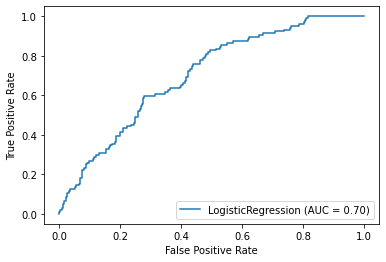

In [142]:
plot_roc_curve(clf, X_test, y_test)